In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import zipfile

pd.options.display.max_rows = 300
pd.options.display.max_seq_items = 300

## Download the data

If the data can't be readily downloaded, default to local file

In [2]:
url = 'https://www.kaggle.com/davidbnn92/weather-data-for-covid19-data-analysis/download'
file = '/home/dustin/School/DM/Project/data.zip'
csv_name = 'training_data_with_weather_info_week_4.csv'

df = None

try:
    urllib.request.urlretreive(url, file)
    zf = zipfile.ZipFile(file)
    df = pd.read_csv(zf.open(csv_name, parse_dates=True))

except: 
    df = pd.read_csv(csv_name, parse_dates=True)



In [3]:
df = pd.read_csv('training_data_with_weather_info_week_4.csv', parse_dates=True)

df

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities,country+province,Lat,Long,day_from_jan_first,...,min,max,stp,slp,dewp,rh,ah,wdsp,prcp,fog
0,1,Afghanistan,NaN,2020-01-22,0.0,0.0,Afghanistan-,33.000000,65.000000,22,...,33.6,54.9,999.9,1024.3,27.4,0.545709,0.186448,9.4,0.00,0
1,2,Afghanistan,NaN,2020-01-23,0.0,0.0,Afghanistan-,33.000000,65.000000,23,...,32.7,55.9,999.9,1020.8,22.8,0.461259,0.163225,14.9,99.99,1
2,3,Afghanistan,NaN,2020-01-24,0.0,0.0,Afghanistan-,33.000000,65.000000,24,...,36.9,43.2,999.9,1018.6,34.5,0.801794,0.325375,10.4,0.17,1
3,4,Afghanistan,NaN,2020-01-25,0.0,0.0,Afghanistan-,33.000000,65.000000,25,...,37.9,56.3,999.9,1018.0,37.8,0.728175,0.214562,6.1,0.57,1
4,5,Afghanistan,NaN,2020-01-26,0.0,0.0,Afghanistan-,33.000000,65.000000,26,...,36.1,53.1,999.9,1014.8,33.2,0.685513,0.231656,10.8,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24409,35642,Zimbabwe,NaN,2020-04-04,9.0,1.0,Zimbabwe-,-17.829167,31.052222,95,...,66.2,80.6,999.9,NaN,53.9,0.481730,0.130122,4.2,0.00,0
24410,35643,Zimbabwe,NaN,2020-04-05,9.0,1.0,Zimbabwe-,-17.829167,31.052222,96,...,66.2,80.6,999.9,NaN,53.9,0.481730,0.130122,4.2,0.00,0
24411,35644,Zimbabwe,NaN,2020-04-06,10.0,1.0,Zimbabwe-,-17.829167,31.052222,97,...,66.2,80.6,999.9,NaN,53.9,0.481730,0.130122,4.2,0.00,0
24412,35645,Zimbabwe,NaN,2020-04-07,11.0,2.0,Zimbabwe-,-17.829167,31.052222,98,...,66.2,80.6,999.9,NaN,53.9,0.481730,0.130122,4.2,0.00,0


## Data Preparation

What are we going to add to the data?

### Rates of change

We want to get the daily rate of change for infected cases. It may not be entierly useful since the rate of change can be negative torwards the end, so we also want to get the maxima, and probably the minima as well.

In [4]:
list(df)

['Id',
 'Country_Region',
 'Province_State',
 'Date',
 'ConfirmedCases',
 'Fatalities',
 'country+province',
 'Lat',
 'Long',
 'day_from_jan_first',
 'temp',
 'min',
 'max',
 'stp',
 'slp',
 'dewp',
 'rh',
 'ah',
 'wdsp',
 'prcp',
 'fog']

In [5]:
# initial sort, group by country/province and then order by date
df.sort_values(by=['country+province', 'Date'])

# pct: previous item rate of change, here we get a single rate of change for one date to another
df['Infection_rate'] = df.groupby(['country+province'])['ConfirmedCases'].pct_change()

# get rid of any inf values
df.replace(np.inf, np.NaN, inplace=True)

# we dont want 0's counted when doing the mean for 
# infection rates, being np.NaN they will be ignored.
df.replace(0, np.NaN, inplace=True)

df = df.join(df.groupby('country+province')['Infection_rate'].mean().rename('average_infection_rate').to_frame(), on='country+province')

df = df.join(df.groupby('country+province')['Infection_rate'].min().rename('min_infection_rate').to_frame(), on='country+province')

df = df.join(df.groupby('country+province')['Infection_rate'].max().rename('max_infection_rate').to_frame(), on='country+province')

print(list(df))

df.fillna(0)


#print("Average infeciton rates\n" + str(df['average_infection_rate']) + "\n")
#print("Min infeciton rates\n" + str(df['min_infection_rate']) + "\n")
#print("Max infeciton rates\n" + str(df['max_infection_rate']) + "\n")

# at my time of running this: 0.37013752128455507
#print(f'Average infection rate: {average_infection_rates.mean()}')

to_plot = df

['Id', 'Country_Region', 'Province_State', 'Date', 'ConfirmedCases', 'Fatalities', 'country+province', 'Lat', 'Long', 'day_from_jan_first', 'temp', 'min', 'max', 'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp', 'fog', 'Infection_rate', 'average_infection_rate', 'min_infection_rate', 'max_infection_rate']


In [6]:
list(df)

['Id',
 'Country_Region',
 'Province_State',
 'Date',
 'ConfirmedCases',
 'Fatalities',
 'country+province',
 'Lat',
 'Long',
 'day_from_jan_first',
 'temp',
 'min',
 'max',
 'stp',
 'slp',
 'dewp',
 'rh',
 'ah',
 'wdsp',
 'prcp',
 'fog',
 'Infection_rate',
 'average_infection_rate',
 'min_infection_rate',
 'max_infection_rate']

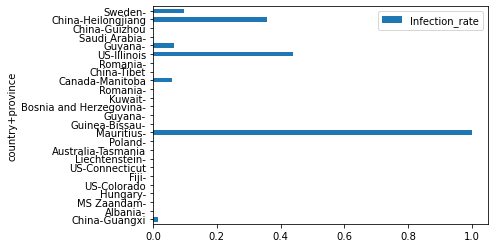

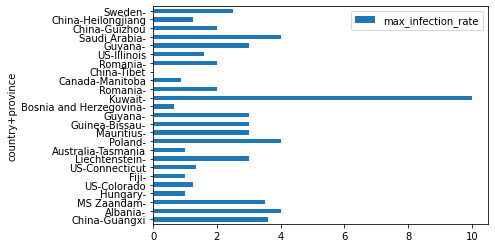

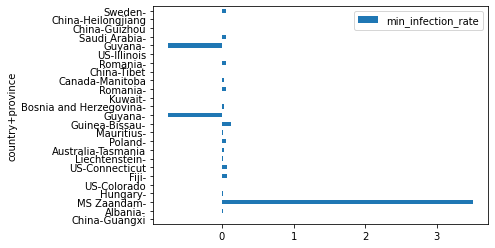

In [7]:
df.sample(n=25, random_state=1).plot.barh(x='country+province', y='Infection_rate', rot=0)
df.sample(n=25, random_state=1).plot.barh(x='country+province', y='max_infection_rate', rot=0)
df.sample(n=25, random_state=1).plot.barh(x='country+province', y='min_infection_rate', rot=0)

plt.show(block=True)

In [8]:
list(df)

df.to_csv(r'processed_data.csv', index = False)